In [24]:
import cv2 as cv
import numpy as np
import os
import shutil
import torch
import random
import torchvision
from torch.utils.data import random_split, Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image, ImageOps, ImageEnhance
from torchvision.transforms import functional as F

# Para solucionar un posible problema con plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [25]:
def filter(image, debug = 0):
    #Pasamos la imagen a una escala de grises
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    #Aplicamos un filtro gausiano para eliminar ruido
    blur = cv.GaussianBlur(gray, (5, 5), 0)
    #Convertimos la imagen a blanco y negro
    ret, thresh = cv.threshold(blur, 75, 255, cv.THRESH_BINARY_INV)
    #Mostramos la imagen si es necesario
    if debug != 0:
        cv.imwrite("filter.png", thresh)
    return ret, thresh

def centroid(image, debug = 0):
    #Encontramos todos los contornos
    contours, hierarchies = cv.findContours(image, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    if len(contours) != 0:  
        #Escogemos el contorno con mayor area
        c = max(contours, key = cv.contourArea)
        #Realizamos el cálculo de los centroides
        M = cv.moments(c)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            if debug != 0:
                print(f"x: {cx} y: {cy}")
    return cx, cy

In [26]:
def crop(path, new_path, type):
    i = 0
    for item in os.listdir(path):
        if os.path.isfile(os.path.join(path, item)):
            image = cv.imread(os.path.join(path, item))
            if image is not None:
                ret, thresh = filter(image)
                cx, cy = centroid(thresh)
                w = 215
                imageOut = image[cy-w:cy+w+1, cx-w:cx+w+1]
                #Renombramos los archivos
                name = str(i) + "_" + type + ".png"
                i = i + 1
                try:
                    cv.imwrite(os.path.join(new_path, name), imageOut)
                except:
                    continue

In [27]:
no_fail_path = "Dataset/Original/Sin Fallo"
fail_path = "Dataset/Original/Con Fallo"

new_no_fail_path =  "Dataset/Cortado/Sin Fallo"
new_fail_path =  "Dataset/Cortado/Con Fallo"

if os.path.exists(new_no_fail_path): shutil.rmtree(new_no_fail_path)
os.makedirs(new_no_fail_path)

if os.path.exists(new_fail_path): shutil.rmtree(new_fail_path)
os.makedirs(new_fail_path)

crop(no_fail_path, new_no_fail_path, "nofail")
crop(fail_path, new_fail_path, "fail")

In [ ]:
#Comprobamos si disponemos de GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.0  Device: cuda


In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
    #Get a list of all the file names
    images = list(file for file in os.listdir(SOURCE_DIR) if os.path.isfile(os.path.join(SOURCE_DIR, file)))
    #Now that we have our image filenames, we randomly shuffle them to be used for validation and training
    images = random.sample(images, len(images))
    #In this section, I decided to split data with the following ratio: 10% validation data, 90% training data. I first populate validation data 
    for i in range(len(images)):
        if i < len(images) *(0.08):
            shutil.copyfile(os.path.join(SOURCE_DIR, images[i]), os.path.join(TEST_DIR, images[i]))
        elif i < len(images) *(0.28):
            shutil.copyfile(os.path.join(SOURCE_DIR, images[i]), os.path.join(VALIDATION_DIR, images[i]))
        else:
            shutil.copyfile(os.path.join(SOURCE_DIR, images[i]), os.path.join(TRAINING_DIR, images[i]))

In [ ]:
def split_data2(dataset, test_size=.2):
    L = len(dataset)
    n_second = int(L*test_size)
    n_first = L - n_second
    first_split, second_split = random_split(dataset, lengths=[n_first, n_second])
    return first_split, second_split

In [ ]:
#TRAIN_PATH = "Dataset/train" #Ruta de los datos de entrenamiento
#VAL_PATH = "Dataset/validation" #Ruta de los datos de validación
#TEST_PATH = "Dataset/test" #Ruta de los datos de test

#if os.path.exists(TRAIN_PATH): shutil.rmtree(TRAIN_PATH)
#os.makedirs(TRAIN_PATH)

#if os.path.exists(VAL_PATH): shutil.rmtree(VAL_PATH)
#os.makedirs(VAL_PATH)

#if os.path.exists(TEST_PATH): shutil.rmtree(TEST_PATH)
#os.makedirs(TEST_PATH)

#split_data(new_no_fail_path, TRAIN_PATH, VAL_PATH, TEST_PATH)
#split_data(new_fail_path, TRAIN_PATH, VAL_PATH, TEST_PATH)

DATASET_PATH = "Dataset/Cortado"

dataset = torchvision.datasets.ImageFolder(DATASET_PATH)

training_dataset, validation_dataset = split_data2(dataset, test_size = 0.2)
training_dataset, test_dataset = split_data2(training_dataset, test_size = 0.1)

In [ ]:
class SubsetTransforms(Dataset):
    def __init__(self, subset, transforms):
        self.subset = subset
        self.transforms = transforms
        
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.transforms(x), y

    def __len__(self):
        return len(self.subset)

    def show_image(self, index):        
        filename = os.path.join(self.subset, self.images[index])
        img_array = np.array(Image.open(filename))
        plt.imshow(img_array)

In [ ]:
def show(dataset, N=5, labels=None, figsize=(20, 20)):
    """ Shows random N samples from the dataset """
    idxs = np.random.randint(0, len(dataset)-1, N)

    fig, axs = plt.subplots(ncols=len(idxs), squeeze=False, figsize=figsize)

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        
        if isinstance(sample, tuple): # then it is in the form (x, y)
            sample, label = sample
            if isinstance(label, torch.TensorType):
                label = int(label.item())
            if labels:
                label = labels[label]
            axs[0, i].title.set_text(label)

        axs[0, i].imshow(F.to_pil_image(sample))
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

    plt.show()

In [ ]:
batch_size = 32

transform = transforms.Compose([
                                transforms.Resize((200,200)),
                                transforms.RandomRotation(15),
                                transforms.RandomHorizontalFlip(30),
                                transforms.ToTensor(),
                                #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                               ])

training_dataset = SubsetTransforms(training_dataset, transform)
test_dataset = SubsetTransforms(test_dataset, transform)
validation_dataset = SubsetTransforms(validation_dataset, transform)

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

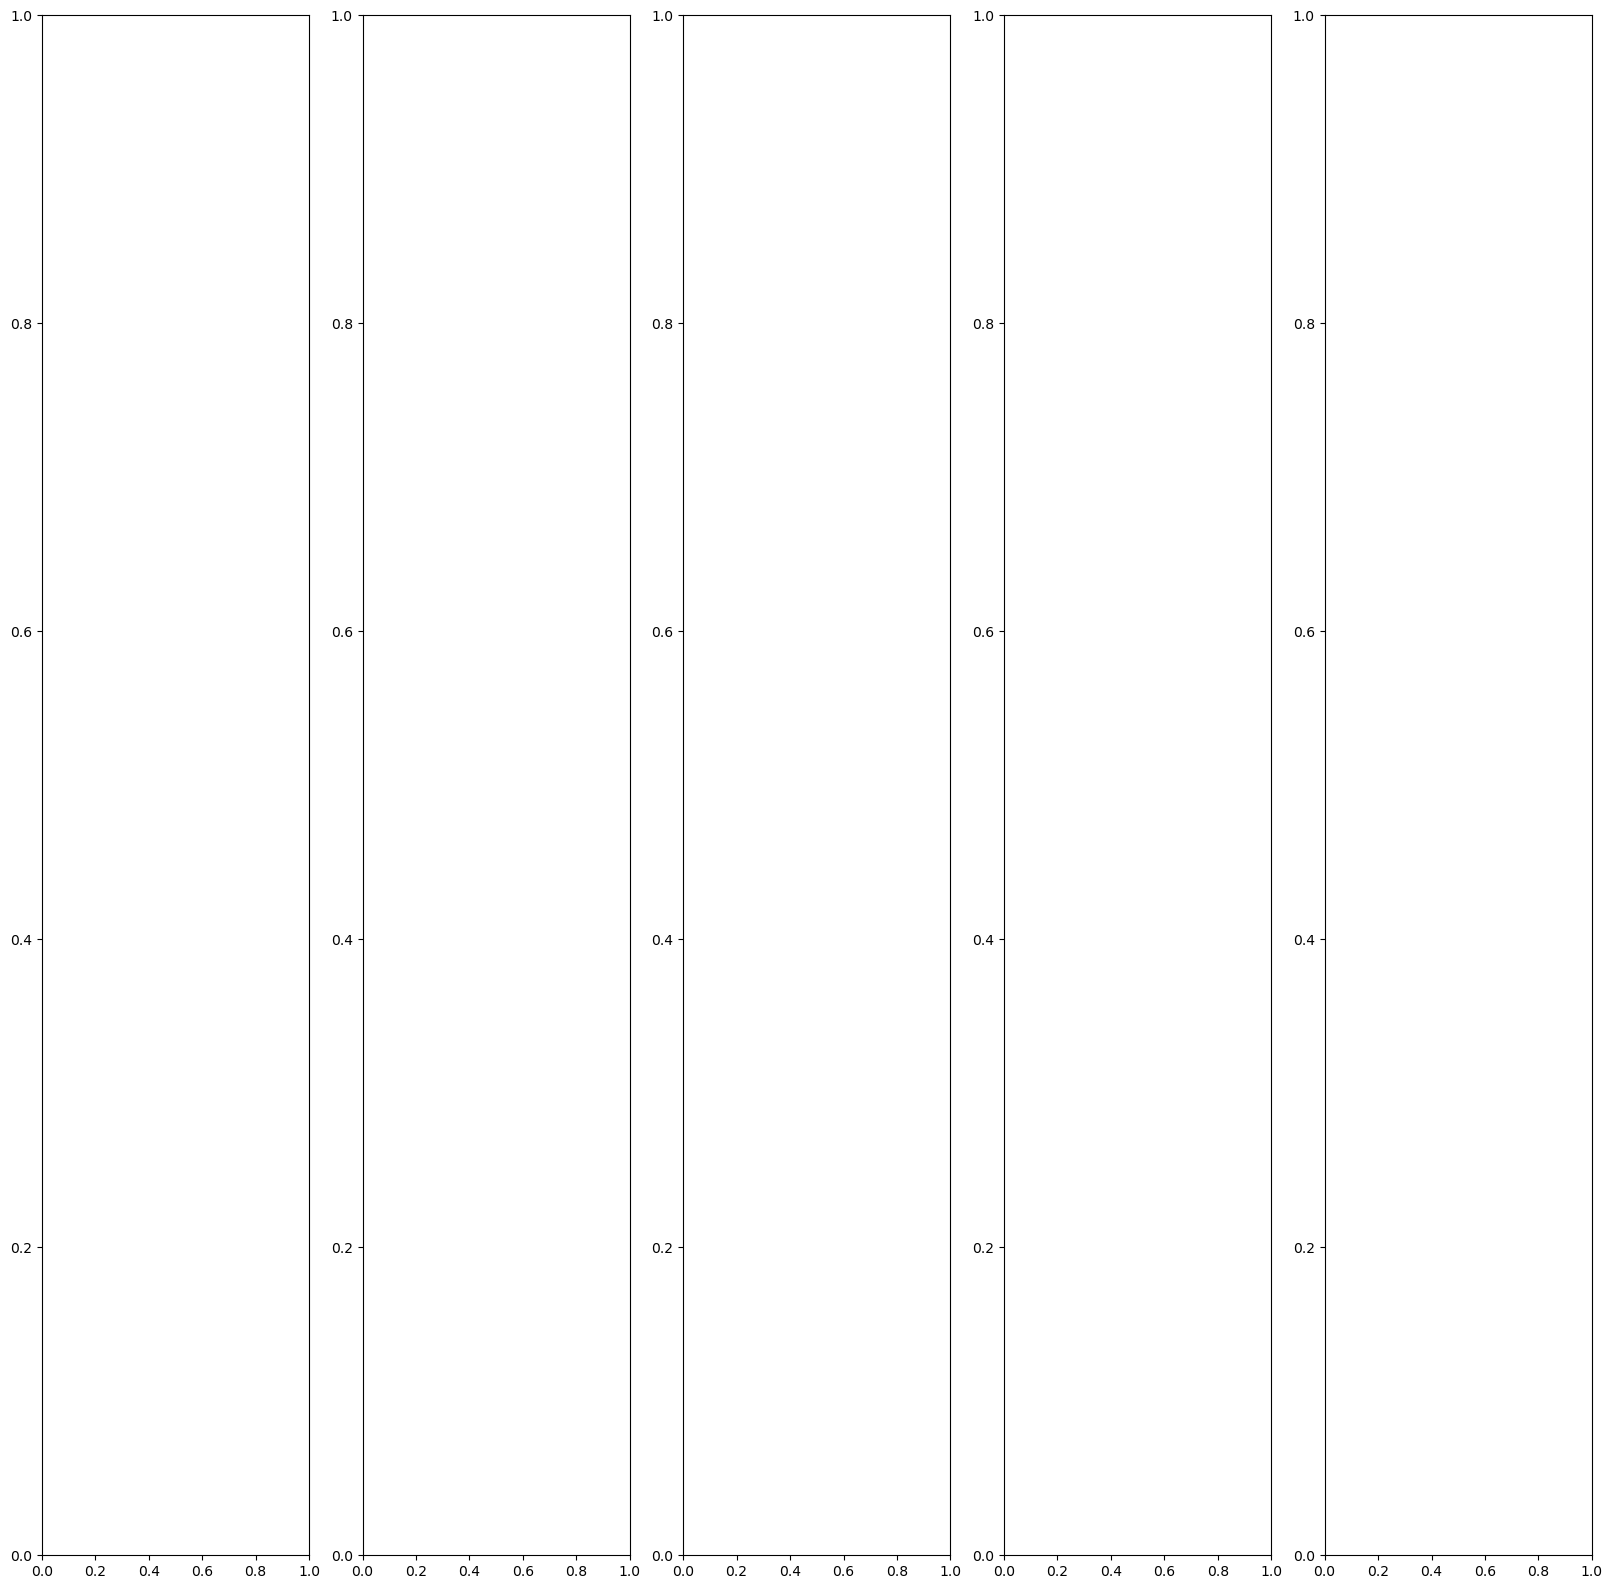

In [ ]:
labels_to_idx = {"nofail":1, "fail":0}
idx_to_labels = {0: "fail", 1: "nofail"}

show(training_dataset, labels=idx_to_labels)